In [71]:
# conectar el entorno con drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
#instalamos ultralytics
!pip install ultralytics > /dev/null 2>&1

In [73]:
#carga de librerias
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import time
from IPython.display import HTML
from base64 import b64encode

# Modelo con 10 capas congeladas

## Entrenamiento del modelo 1

In [74]:
# Ruta al archivo .yaml con la configuración del dataset
yaml_path = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/data.yaml")

# Ruta al modelo base de YOLO (preentrenado)
MODEL_WEIGHTS = "yolov8s-seg.pt"  #se uso el modelo de segmentación

# Tamaño de las imágenes de entrenamiento
IMG_SIZE = 256

In [75]:
#miramos el contenido del yaml
print(yaml_path.read_text())

path: /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz
#path: . #para usar en local

train: data/images/train
val: data/images/val

nc: 1
names: ['holes']

roboflow:
  workspace: vision-grietas-y-huecos
  project: huecos254544
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/vision-grietas-y-huecos/huecos254544/dataset/1


Función para realizar fine tuning

https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml

In [147]:
def fine_tune(yaml_path: Path, freeze_depth: int, epocas: int):
  model = YOLO(MODEL_WEIGHTS)

  model.train(
      data=str(yaml_path),
      epochs=epocas,
      imgsz=IMG_SIZE,
      freeze=freeze_depth,

      patience=30,       # early‑stopping
      batch=16,           # tamaño de batch
      box=4              # factor de pérdida para las cajas (bounding box loss), controla la importancia de ajustar bien las cajas durante el entrenamiento

  )
  return model

In [148]:
# Número de épocas de entrenamiento
EPOCHS = 200
modelo_finetuneado = fine_tune(yaml_path, freeze_depth=10, epocas=EPOCHS)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=4, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train15, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

train: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/train.cache... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 5.5±3.8 MB/s, size: 13.6 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs/segment/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train15
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.46G      0.705      1.407      2.743      1.311         10        256: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         21         33      0.459      0.636      0.439      0.256      0.451      0.576      0.416      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.46G     0.6206     0.9972      1.269      1.245          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         21         33      0.605      0.557      0.565      0.334       0.56      0.515      0.512      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.46G     0.5532     0.9208      1.027      1.147          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         21         33      0.783      0.545      0.588      0.375      0.783      0.545      0.609      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.46G     0.6065     0.9273      1.015      1.227         11        256: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         21         33      0.216      0.636      0.177     0.0964      0.206      0.606      0.169     0.0839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.46G     0.5941      0.857     0.9607      1.212          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.155      0.485      0.173     0.0958      0.184      0.576      0.185        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.46G     0.6189      0.869      1.003      1.192         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         21         33      0.128      0.636      0.142     0.0661      0.122      0.606      0.128     0.0596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.46G     0.6141     0.8324     0.9344      1.196         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.429      0.545      0.313      0.185      0.405      0.515      0.283      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.46G     0.6371     0.8165     0.8565      1.212         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         21         33      0.552      0.606       0.51      0.273      0.537      0.576      0.493       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.46G     0.6275     0.8415     0.8831      1.215         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.565       0.59      0.549      0.301      0.536       0.56      0.519      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.46G     0.5892     0.8187     0.8441       1.19         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.613      0.364      0.352      0.108      0.749      0.452      0.422      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.46G     0.6062     0.8357     0.8396      1.173          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33      0.583      0.455       0.41      0.149      0.554      0.424       0.42      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.46G     0.6121     0.8349     0.8251      1.161          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         21         33      0.597      0.545       0.56      0.285       0.51      0.636      0.555      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.46G     0.5569     0.8156     0.7961      1.125          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33      0.658      0.545      0.574      0.325      0.669      0.576      0.599       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.46G     0.6076      0.918     0.8187      1.166          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         21         33      0.451      0.394       0.31      0.125      0.382      0.394      0.297      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.46G      0.601     0.7795     0.8318      1.158         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         21         33      0.507      0.545      0.532      0.303      0.507      0.545      0.522       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.46G     0.5709     0.7676      0.786      1.124         16        256: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         21         33      0.764      0.545       0.63      0.351      0.764      0.545      0.613      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.46G     0.5827     0.8133     0.8063      1.195         11        256: 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.781      0.636      0.654      0.381      0.781      0.636      0.651      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.46G     0.5508     0.7545      0.742      1.154         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         21         33      0.605      0.636      0.591      0.287      0.605      0.636      0.591      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.46G     0.5623     0.7768     0.7094      1.142         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         33      0.683      0.587      0.606      0.265      0.683      0.587      0.611      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.46G      0.552     0.6695     0.6781      1.119         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         21         33      0.757      0.515      0.546       0.24      0.757      0.515      0.548      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.51G     0.5584     0.7996     0.6902      1.099         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         21         33       0.84      0.478       0.62       0.32       0.84      0.478      0.616      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.57G      0.536     0.7121     0.6813      1.088         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         21         33      0.744      0.515      0.566      0.277      0.744      0.515      0.569      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.57G     0.5287     0.7211     0.6738      1.087         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33      0.586      0.515      0.495      0.251      0.586      0.515      0.495      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.57G     0.5379     0.8205      0.682      1.099          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         21         33      0.744      0.515      0.617      0.343      0.727      0.566      0.669      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.57G     0.5171     0.7502     0.6812      1.086          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.728      0.576      0.581      0.294      0.728      0.576      0.604      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.57G     0.5369     0.7223     0.6576      1.088         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         21         33      0.862      0.515      0.643      0.322      0.862      0.515      0.639      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.57G     0.5048     0.6699     0.6287      1.079         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         33      0.951      0.585      0.699      0.421      0.951      0.585      0.707      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.57G     0.5132     0.6885     0.6418      1.081         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         21         33      0.924      0.485      0.661      0.392      0.744      0.606      0.654       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.57G     0.5346     0.6998     0.6767      1.105          6        256: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         21         33      0.934      0.515      0.626      0.402      0.934      0.515      0.602      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.57G     0.5388     0.7657     0.6786      1.105          9        256: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.796      0.606      0.635      0.344      0.796      0.606      0.651       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.57G     0.5117     0.6893     0.6537      1.099         18        256: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         21         33      0.661      0.606      0.614      0.293      0.661      0.606      0.649      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.61G     0.4846      0.653     0.6313      1.076         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         21         33      0.749      0.576       0.64      0.342      0.749      0.576      0.663      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.61G     0.4823     0.6685     0.6145      1.078          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.941      0.483      0.596      0.322      0.941      0.483      0.571      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.62G     0.5066     0.7029     0.6165      1.053         16        256: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         21         33      0.915      0.485      0.611      0.382      0.915      0.485      0.605      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.62G     0.5266     0.7799     0.6432       1.15          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         21         33      0.962      0.485      0.605      0.315      0.962      0.485      0.557      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.63G     0.5002     0.7186     0.6164      1.069         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         21         33      0.887      0.485      0.648      0.381      0.887      0.485      0.641      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.63G     0.4781     0.6546     0.5923      1.055         14        256: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         21         33      0.937      0.449      0.638      0.369      0.984      0.515      0.641      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.63G     0.4811     0.6199      0.621      1.059         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.661      0.606      0.635      0.323      0.677      0.576      0.627      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.63G     0.5195     0.6762     0.6959      1.121          5        256: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.854      0.515      0.676       0.44      0.854      0.515      0.664      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.63G     0.4686     0.6251     0.5608      1.038         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.923      0.515      0.629      0.413      0.923      0.515      0.616      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.63G     0.4832     0.6296     0.6076      1.031         15        256: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33      0.809      0.545      0.604      0.392      0.809      0.545      0.604       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.63G     0.4885     0.6257     0.5821      1.056          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         21         33      0.898      0.545      0.688      0.426      0.898      0.545      0.649       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.63G     0.4552     0.6328     0.5599      1.059         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         21         33      0.761      0.636      0.689      0.398      0.761      0.636      0.683      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.63G      0.496     0.6828     0.5867      1.083          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         21         33      0.763      0.515      0.606      0.334      0.853      0.576      0.676      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.63G     0.4322     0.6134     0.5504      1.007         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         21         33      0.845      0.576      0.709      0.352      0.851      0.576      0.737      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.63G     0.4383     0.5568     0.5657      1.042          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.789      0.576      0.683      0.342      0.842      0.545      0.716      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.63G     0.4339     0.5673     0.5567      1.035         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.862      0.515      0.687      0.407      0.963      0.576      0.684       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.63G     0.4093     0.5846     0.5264     0.9932         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         21         33       0.87      0.515      0.632      0.378      0.964      0.576      0.665      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.63G     0.4128     0.5766     0.5315      1.003          8        256: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         21         33      0.791      0.576      0.618      0.363      0.872      0.576      0.636      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.63G     0.4355     0.6044     0.5548       1.03         16        256: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33       0.78      0.515      0.523      0.286       0.78      0.515      0.574      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.63G     0.4008     0.5568     0.5165     0.9831         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         21         33          1      0.479       0.61      0.369      0.887      0.606      0.671      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.63G     0.4551     0.6787     0.5561      1.047         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.714      0.576      0.623       0.38        0.8      0.636      0.705      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.63G     0.4229     0.5095      0.536      1.031          6        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.567      0.727      0.635      0.368      0.627      0.818      0.729      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.63G     0.4134     0.5713     0.5275      1.011          6        256: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.945      0.636      0.737      0.429      0.945      0.636      0.733      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.63G     0.4135     0.5859     0.5209      1.001         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.897      0.636      0.707      0.444      0.897      0.636      0.725      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.63G     0.4522     0.5564     0.5493       1.04          9        256: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         21         33      0.896      0.636      0.736      0.399      0.896      0.636      0.719      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.63G     0.4365     0.5934     0.5267      1.023          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         21         33       0.86      0.557      0.684        0.4      0.849      0.636      0.692      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.63G     0.4009     0.5611     0.5004     0.9883         13        256: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         21         33      0.928      0.576      0.682       0.38      0.928      0.576      0.701      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.67G     0.4088     0.5703     0.5224     0.9933         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         21         33      0.877      0.576      0.675      0.391      0.877      0.576      0.702      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.67G     0.4082     0.5676     0.5173      1.023         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         21         33      0.772      0.576      0.654      0.375      0.665      0.661      0.696      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.67G     0.4311     0.5839      0.509     0.9954         21        256: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         21         33       0.71      0.576      0.669       0.37      0.683      0.576      0.696      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.68G     0.4014      0.558     0.5055      1.008         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         21         33      0.581      0.667      0.667      0.366      0.677      0.699      0.745      0.345

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.68G     0.3937      0.539     0.4948     0.9964         13        256: 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         21         33      0.737      0.636      0.721      0.415      0.737      0.636      0.784      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.68G     0.4016     0.5607     0.5086       1.04         11        256: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33       0.71      0.815      0.813      0.431       0.71      0.815      0.813      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.68G     0.4073     0.5591     0.4918      1.001         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         21         33       0.81      0.647       0.76      0.369      0.749      0.727      0.805      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.68G      0.438      0.597      0.515      1.014         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.797      0.636      0.723       0.39      0.881      0.697      0.815      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.68G     0.4336     0.6455     0.5372      1.018          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         21         33      0.708      0.733      0.751      0.415      0.708      0.733      0.747      0.382

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.68G     0.4039      0.528     0.4889     0.9936         18        256: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         21         33      0.661      0.697      0.685       0.35      0.661      0.697      0.682      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.68G      0.394     0.5172     0.4922      0.973         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.654      0.758      0.716      0.388      0.654      0.758      0.724       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.68G     0.4131     0.6167     0.5078     0.9972          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         21         33      0.658      0.667      0.702      0.398      0.742      0.636      0.739      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.68G     0.4236     0.5512     0.4869      1.035         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         21         33      0.827      0.636      0.694      0.311      0.827      0.636      0.713      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.68G     0.3796     0.5054     0.4601     0.9575          9        256: 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         21         33       0.72      0.636       0.63      0.307       0.72      0.636       0.63      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.68G     0.4107     0.5608     0.4907      1.021         11        256: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         21         33      0.722      0.551      0.618        0.3      0.722      0.551       0.64      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.68G     0.4141     0.5872     0.4935      1.012         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         21         33      0.724      0.576      0.587       0.25      0.755      0.606      0.611      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.68G     0.4074     0.5445      0.499     0.9895          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33      0.861      0.515      0.625      0.286      0.865      0.545      0.658      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.68G     0.4182     0.5499     0.5104      1.011         10        256: 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         21         33      0.548      0.788       0.69      0.313      0.713      0.603      0.705      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.68G     0.3716     0.5342     0.4605     0.9593         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         21         33      0.811      0.545      0.698      0.331      0.704      0.727      0.755       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.68G     0.3848     0.5754     0.4555      1.008         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         21         33      0.966      0.545      0.703      0.395      0.718      0.788      0.772      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.68G     0.3791       0.52      0.465     0.9831          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         21         33      0.954      0.545      0.662      0.365      0.954      0.545      0.695      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.68G     0.3888     0.5024     0.4667     0.9731         13        256: 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         21         33      0.854      0.545      0.716      0.366      0.854      0.545      0.732      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.68G     0.3711     0.4896     0.4776     0.9639         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         21         33       0.89      0.606      0.752      0.415      0.919      0.687      0.787      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.68G     0.3464     0.4947     0.4385      0.966         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         21         33        0.9      0.606      0.683      0.401      0.791      0.727      0.755      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.68G     0.3997     0.5078     0.4745     0.9648         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         21         33      0.731      0.606      0.653      0.354      0.731      0.606      0.653       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.68G     0.3721     0.4952     0.4391     0.9894         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         21         33      0.848      0.485      0.611       0.33      0.642      0.606      0.645      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.68G     0.3756      0.532     0.4673      0.976         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         21         33      0.735      0.485      0.558      0.317      0.735      0.485       0.61      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.68G     0.3709     0.4673     0.4498     0.9637         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33      0.799      0.485      0.561      0.267      0.799      0.485      0.593      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.68G     0.3585     0.4947     0.4382      0.945         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         21         33      0.979      0.485      0.599       0.32      0.979      0.485       0.64      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.68G     0.3593     0.5191     0.4399     0.9597         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         21         33      0.946      0.515      0.625      0.338      0.737      0.636      0.678      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.68G     0.3916     0.5496     0.4648     0.9981         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.947       0.54      0.688      0.379      0.947       0.54      0.693      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.68G     0.3673     0.5396     0.4572     0.9624          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         21         33      0.911      0.624      0.738       0.42      0.911      0.624      0.772      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.68G     0.3565     0.5331     0.4486     0.9418         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.915      0.606      0.745      0.423      0.693      0.848      0.829      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.68G     0.3877     0.5118     0.4627     0.9709          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.863      0.636      0.789      0.438      0.778      0.758       0.81      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.68G     0.3703     0.5246      0.463     0.9829         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         21         33      0.888      0.636      0.774        0.4      0.888      0.636      0.791       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.68G      0.364     0.5302     0.4561     0.9709          8        256: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         21         33      0.733      0.636      0.714       0.37      0.733      0.636      0.719      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.68G     0.3618     0.4708     0.4374     0.9439         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33      0.703      0.606      0.657      0.356      0.738      0.636      0.713        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.68G     0.3446     0.4966      0.428      0.967         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.712      0.606      0.654      0.305      0.748      0.636      0.698      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.68G     0.3427     0.4854     0.4509     0.9786          4        256: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.828      0.582      0.668      0.323      0.828      0.582      0.677      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.68G     0.3729     0.4929      0.442     0.9936          8        256: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         21         33      0.726      0.576       0.64       0.33      0.726      0.576      0.669      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.68G     0.3437     0.4577     0.4446     0.9609         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         21         33      0.725       0.56      0.648      0.326      0.725       0.56       0.68      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.68G     0.3624     0.5011     0.4309     0.9662         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         21         33      0.719      0.636      0.698      0.367      0.719      0.636      0.698      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.68G     0.3782     0.5129      0.445      1.013          9        256: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         21         33      0.807      0.515      0.684      0.342      0.807      0.515      0.692      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.68G     0.3731     0.5193       0.45      0.974         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         21         33      0.626      0.576      0.634       0.29      0.626      0.576      0.634      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.68G     0.3647     0.4658     0.4251     0.9728         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         21         33      0.681      0.576       0.65      0.331      0.681      0.576       0.65      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.68G     0.3408     0.4726     0.4397     0.9499         17        256: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         21         33      0.678      0.576      0.662      0.347      0.678      0.576      0.665      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.68G     0.3595      0.531     0.4427     0.9763          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         21         33      0.675      0.576      0.653       0.32      0.675      0.576      0.653      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.68G     0.3638     0.5004     0.4199     0.9356         15        256: 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         21         33      0.659      0.528      0.658      0.349      0.659      0.528      0.669      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.68G     0.3282     0.4161     0.4158       0.94          8        256: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         21         33      0.708      0.576      0.686      0.374      0.708      0.576      0.704      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.68G     0.3418     0.4703     0.4225     0.9617         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         21         33      0.674      0.636      0.718      0.333        0.7      0.636      0.721      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.68G     0.3705     0.5255     0.4379     0.9642         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         21         33      0.771      0.606      0.715      0.339      0.716      0.606      0.718      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.68G       0.35     0.4937     0.4272     0.9555          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         21         33      0.764      0.606       0.72       0.39      0.694      0.619      0.723      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.68G     0.3532     0.4683     0.4392     0.9575         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.765      0.636      0.738      0.399      0.765      0.636      0.738      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.68G     0.3382     0.4892     0.4332     0.9569         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         21         33      0.629      0.721      0.705      0.375      0.682      0.781      0.764      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.68G     0.3457     0.4811     0.4295     0.9668         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         21         33      0.727      0.636      0.715       0.43      0.772      0.719      0.767       0.42

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.68G     0.3302     0.4611     0.4103     0.9659         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         21         33      0.796      0.593      0.748      0.405      0.796      0.593      0.748       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.68G     0.3447     0.4852      0.417     0.9412         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         21         33      0.864      0.579      0.687      0.362      0.864      0.579      0.698      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.68G     0.3263       0.44     0.3995     0.9404         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.869      0.606      0.681       0.42      0.869      0.606      0.711      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.68G     0.3455     0.4857      0.413     0.9919          5        256: 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         21         33      0.894      0.606      0.683      0.438      0.894      0.606      0.704      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.68G     0.3409     0.4379     0.4111     0.9496         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         21         33      0.897      0.606      0.681      0.405      0.897      0.606      0.723      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.68G      0.355     0.4508     0.4123     0.9723          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.879      0.545      0.678      0.359      0.879      0.545      0.727      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.68G     0.3222      0.464     0.4146     0.9184         20        256: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         21         33      0.899      0.606      0.743      0.373      0.899      0.606      0.743      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.68G     0.3347     0.4675     0.4196     0.9334         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         21         33      0.974      0.606      0.775      0.441      0.974      0.606      0.775      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.68G     0.3438     0.5027     0.4205     0.9638         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         21         33      0.978      0.606       0.77      0.392      0.978      0.606       0.77      0.429
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 92, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



122 epochs completed in 0.122 hours.
Optimizer stripped from runs/segment/train15/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train15/weights/best.pt, 54.8MB

Validating runs/segment/train15/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


                   all         21         33      0.862      0.636      0.781      0.437      0.758      0.759      0.803      0.445
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train15


En YOLOv8, el *backbone* es la parte inicial de la red neuronal encargada de extraer características generales de las imágenes, como bordes, texturas y formas básicas. Funciona como un extractor de representaciones visuales útiles que luego son procesadas por las capas posteriores del modelo (llamadas *head*) para realizar tareas específicas como la detección o segmentación de objetos. Al entrenar nuestro modelo, decidimos congelar el *backbone*, lo cual significa que sus pesos no se actualizan durante el entrenamiento. Esta decisión nos permitió aprovechar características previamente aprendidas en grandes conjuntos de datos (como COCO) y concentrar el aprendizaje del modelo únicamente en las capas finales encargadas de identificar huecos en el contexto urbano. Congelar el *backbone* reduce el tiempo de entrenamiento, disminuye el riesgo de *overfitting* y es especialmente útil cuando se dispone de un conjunto de datos pequeño, como en nuestro caso.


In [149]:
# Validar el modelo (conjunto de validación debe estar correctamente estructurado)
results = modelo_finetuneado.val()

# Ver resultados principales de forma ordenada
print("Precisión (mAP50):", results.box.map50)
print("Precisión (mAP50-95):", results.box.map)
print("Precisión por clase:", results.box.maps)  # Array con mAP50-95 por clase

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 8.9±3.7 MB/s, size: 13.5 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  2.70it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


                   all         21         33      0.863      0.636       0.78      0.437      0.779      0.758      0.809      0.448
Speed: 0.3ms preprocess, 11.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train152
Precisión (mAP50): 0.7800372389994127
Precisión (mAP50-95): 0.43670702654592075
Precisión por clase: [    0.43671]


Precisión (mAP50): 0.7800
Es la media de la precisión promedio (mAP) considerando un umbral de IoU (Intersection over Union) del 50%. Un valor de 0.78 indica que el modelo detecta correctamente los objetos en el 78% de los casos bajo este criterio.

Precisión (mAP50-95): 0.4367
Es la mAP promedio calculada en múltiples umbrales de IoU (del 50% al 95% en pasos de 5%). Es una métrica más estricta y completa, mostrando que el modelo tiene un desempeño general del 43.67% considerando diferentes niveles de solapamiento.

Precisión por clase: [0.43671]
Es la mAP50-95 calculada individualmente para cada clase. En este caso, solo hay una clase (por ejemplo, "bache"), y su precisión es 0.4367.

In [150]:
#guardar el modelo
modelo_finetuneado.save('/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned1.pt')

## Testeo del modelo 1

In [151]:
fuente_imagenes = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test")
ruta_modelo = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned1.pt")

model = YOLO(ruta_modelo)

In [152]:
resultados = model.predict(source=fuente_imagenes, conf=0.6, imgsz=IMG_SIZE)


image 1/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1359.jpg: 256x256 3 holess, 15.1ms
image 2/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_136.jpg: 256x256 (no detections), 16.6ms
image 3/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1360.jpg: 256x256 1 holes, 15.1ms
image 4/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1361.jpg: 256x256 1 holes, 15.7ms
image 5/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1362.jpg: 256x256 1 holes, 15.1ms
image 6/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_14.jpg: 256x256 2 holess, 15.0ms
image 7/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1421.jpg: 256x256 2 holess, 15.0

Imagen 0 tiene 3 segmentaciones


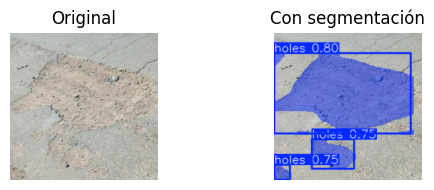

Imagen 1 no tiene segmentaciones


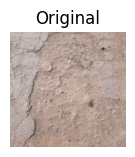

Imagen 2 tiene 1 segmentaciones


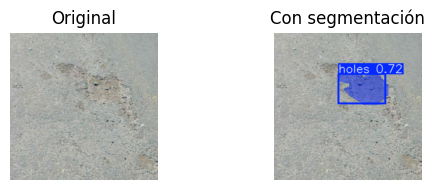

Imagen 3 tiene 1 segmentaciones


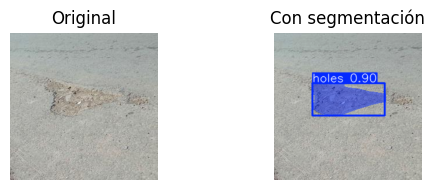

Imagen 4 tiene 1 segmentaciones


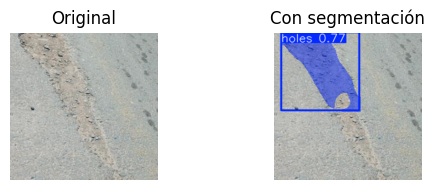

Imagen 5 tiene 2 segmentaciones


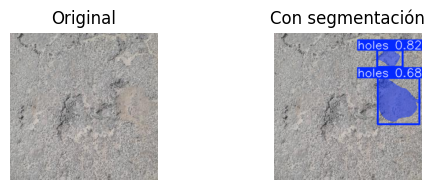

Imagen 6 tiene 2 segmentaciones


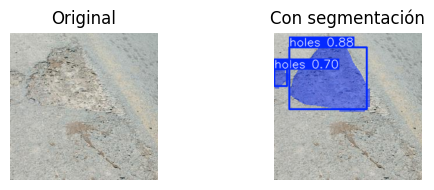

Imagen 7 no tiene segmentaciones


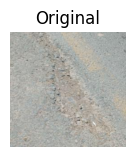

Imagen 8 tiene 1 segmentaciones


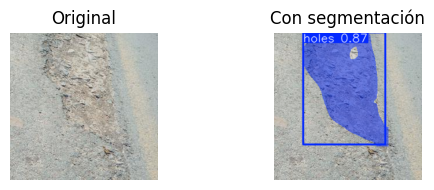

Imagen 9 tiene 1 segmentaciones


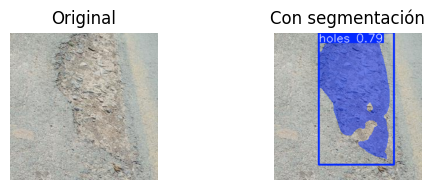

Imagen 10 no tiene segmentaciones


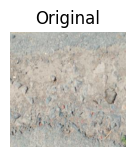

Imagen 11 tiene 1 segmentaciones


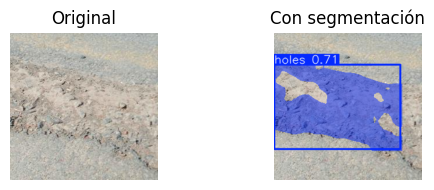

Imagen 12 no tiene segmentaciones


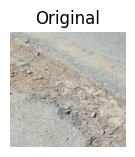

Imagen 13 tiene 1 segmentaciones


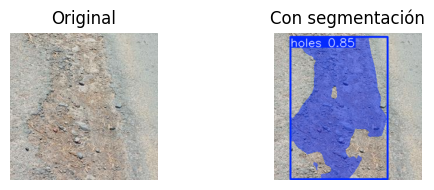

Imagen 14 no tiene segmentaciones


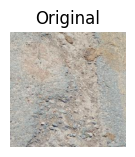

Imagen 15 no tiene segmentaciones


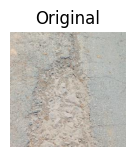

Imagen 16 no tiene segmentaciones


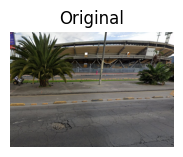

Imagen 17 tiene 1 segmentaciones


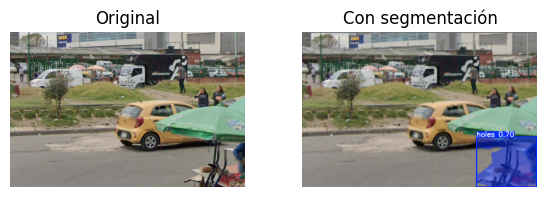

Imagen 18 tiene 3 segmentaciones


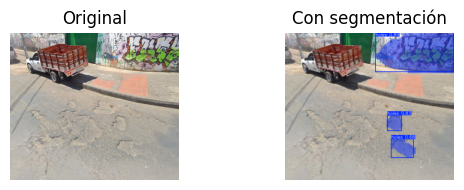

In [153]:
for i, res in enumerate(resultados):
    img_orig = res.orig_img  # Imagen original
    if res.masks is not None and len(res.masks.data) > 0:
        print(f"Imagen {i} tiene {len(res.masks.data)} segmentaciones")

        # Imagen segmentada con detecciones/máscaras dibujadas
        img_segmented = res.plot()

        # Convertir BGR a RGB para matplotlib
        img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_segmented_rgb = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB)

        # Mostrar ambas imágenes en un subplot
        plt.figure(figsize=(6, 2))

        # Izquierda: original
        plt.subplot(1, 2, 1)
        plt.imshow(img_orig_rgb)
        plt.title("Original")
        plt.axis("off")

        # Derecha: segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(img_segmented_rgb)
        plt.title("Con segmentación")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Imagen {i} no tiene segmentaciones")
        plt.figure(figsize=(4, 1.5))
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")
        plt.show()

### Test video

In [154]:
ruta_video = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/video_test/video_huecos.mp4")

In [155]:
# Obtener nombres de las clases
class_names = model.names

# Abrir el video original
cap = cv2.VideoCapture(ruta_video)
count = 0

# Obtener FPS y tamaño del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = 1020
height = 500

# Crear VideoWriter para guardar el video procesado
output_path = '/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/output_video1.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps // 3, (width, height))  # 1 de cada 3 frames

while True:
    ret, img = cap.read()
    if not ret:
        break

    #print("reading frame")

    count += 1
    if count % 3 != 0:
        continue

    img = cv2.resize(img, (width, height))
    h, w, _ = img.shape

    # Realizar predicción
    results = model.predict(img, conf=0.2)

    for r in results:
        boxes = r.boxes
        masks = r.masks

    if masks is not None:
        masks = masks.data.cpu()
        for seg, box in zip(masks.numpy(), boxes):
            seg = cv2.resize(seg, (w, h))
            contours, _ = cv2.findContours((seg).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                d = int(box.cls)
                c = class_names[d]
                x, y, x1, y1 = cv2.boundingRect(contour)
                cv2.polylines(img, [contour], True, color=(0, 0, 255), thickness=2)
                cv2.putText(img, c, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Escribir frame en el video final
    out.write(img)

cap.release()
out.release()

print("✅ Video procesado y guardado correctamente.")


0: 128x256 2 holess, 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 2.3ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 1 holes, 16.6ms
Speed: 0.9ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 2 holess, 14.5ms
Speed: 1.2ms preprocess, 14.5ms inference, 2.4ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 2 holess, 14.2ms
Speed: 1.2ms preprocess, 14.2ms inference, 2.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 1 holes, 15.5ms
Speed: 0.9ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 1 holes, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 1 holes, 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 2.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 (no detections), 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 0.6ms postprocess per image at shape (1, 3,

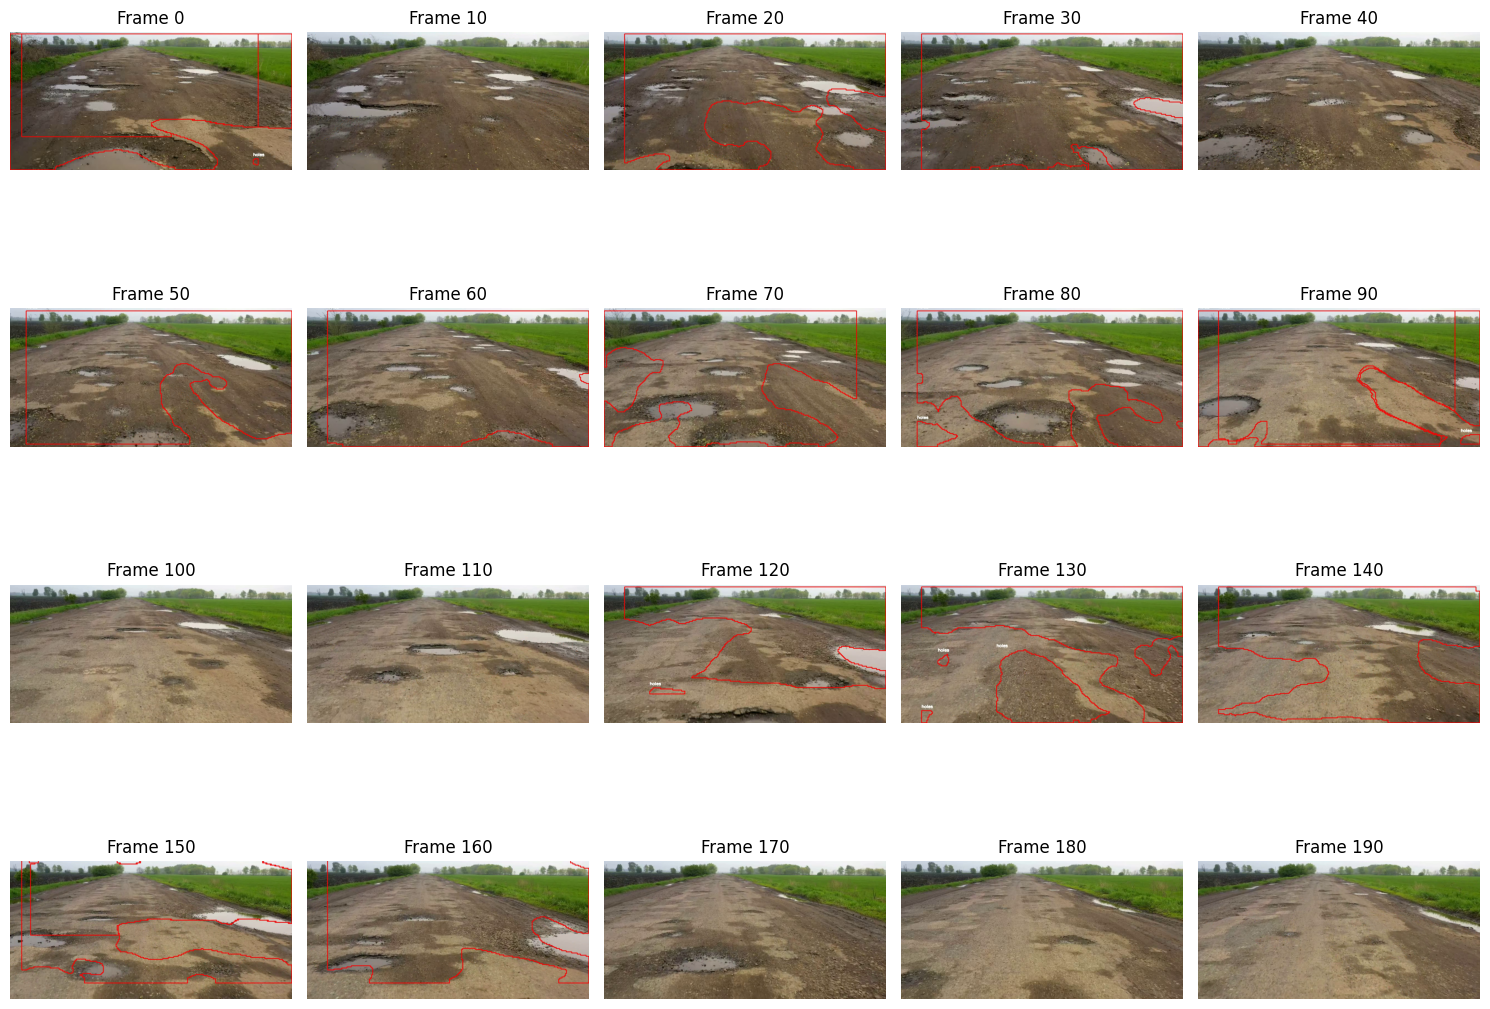

In [156]:
# código para graficar algunas de los frames del video

cap = cv2.VideoCapture(output_path)

# Parámetros
frame_interval = 10  # Mostrar un frame cada 10
max_frames = 20      # Mostrar máximo 20 frames

frames = []
count = 0

# Extraer los frames
while len(frames) < max_frames and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if count % frame_interval == 0:
        # Convertir de BGR (OpenCV) a RGB (matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    count += 1

cap.release()

# Mostrar los frames con matplotlib
cols = 5
rows = (len(frames) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i, f in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(f)
    plt.axis('off')
    plt.title(f'Frame {i * frame_interval}')

plt.tight_layout()
plt.show()

# Modelo con 15 capas congeladas

## Entrenamiento del modelo cambiando capas a congelar 15

In [157]:
def fine_tune(yaml_path: Path, freeze_depth: int, epocas: int):
  model = YOLO(MODEL_WEIGHTS)

  model.train(
      data=str(yaml_path),
      epochs=epocas,
      imgsz=IMG_SIZE,
      freeze=freeze_depth,

      patience=30,       # early‑stopping
      batch=16,           # tamaño de batch
      box=4              # factor de pérdida para las cajas (bounding box loss), controla la importancia de ajustar bien las cajas durante el entrenamiento

  )
  return model

In [158]:
# Número de épocas de entrenamiento
EPOCHS = 200
modelo_finetuneado = fine_tune(yaml_path, freeze_depth=15, epocas=EPOCHS)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=4, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=15, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train16, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

train: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/train.cache... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.0±1.3 ms, read: 8.0±3.0 MB/s, size: 13.6 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs/segment/train16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train16
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.18G     0.6819      1.309      2.711      1.258         10        256: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         21         33      0.482      0.451      0.419      0.245      0.482      0.451      0.404      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.18G     0.6301     0.9911      1.324       1.26          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         21         33     0.0867      0.455      0.114     0.0757      0.092      0.242      0.095     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.18G     0.5664     0.9298      1.102      1.153          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         21         33      0.164      0.545      0.143     0.0864      0.155      0.515       0.13     0.0677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.18G     0.6034     0.9627      1.006      1.217         11        256: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         21         33      0.171      0.818      0.206      0.114      0.177      0.606      0.187      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.18G     0.5992     0.8907     0.9753      1.214          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         21         33        0.6      0.455      0.425       0.22       0.52      0.394       0.34      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.18G     0.6139     0.8996     0.9529      1.194         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33        0.8      0.485      0.587      0.359        0.8      0.485      0.608      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.18G     0.6247     0.8643     0.8935      1.222         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.733      0.333      0.588      0.285      0.733      0.333      0.548      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.18G     0.6199     0.8761     0.8571      1.206         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         21         33      0.439      0.636      0.595      0.324      0.481      0.697      0.618      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.18G     0.6181     0.8351     0.8981      1.215         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.478      0.545      0.519      0.297      0.478      0.545      0.512      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.21G     0.6221     0.8709     0.8753      1.219         13        256: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.688      0.515      0.542      0.247      0.729      0.545      0.543      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.25G     0.6458     0.8928     0.9463      1.232          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         21         33      0.589      0.576      0.497      0.201      0.559      0.545       0.48      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.25G      0.614     0.8537     0.8554      1.189          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         21         33      0.625      0.545      0.594      0.347      0.625      0.545      0.557      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.26G      0.606     0.8048     0.8416      1.165          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         21         33      0.609      0.636      0.559      0.333      0.605      0.636      0.583      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.26G      0.635     0.9729     0.8137      1.204          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33       0.48      0.758       0.65      0.377      0.582      0.576       0.63      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.26G     0.5611     0.8269     0.7595      1.136         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33        0.5      0.728      0.563      0.299      0.563      0.515      0.572      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.31G     0.5862     0.8067     0.8202      1.147         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         21         33      0.684      0.727       0.69      0.392      0.684      0.727      0.678      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.35G     0.5743     0.8559     0.8253      1.181         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         21         33      0.696      0.455      0.556      0.326      0.696      0.455      0.536      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.42G      0.575     0.7972     0.8391        1.2         10        256: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.649      0.636      0.625      0.314      0.619      0.606      0.596      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.42G     0.5734     0.8063     0.8155      1.185         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         21         33      0.789      0.567      0.618       0.31      0.831      0.636      0.667      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.42G     0.5598     0.7107     0.7419       1.14         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.713      0.529      0.619      0.393      0.603       0.69      0.667       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.42G     0.5599     0.7966     0.7116      1.108         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         21         33      0.864      0.576      0.693      0.406      0.864      0.576      0.724       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.42G     0.5268     0.7489      0.684       1.09         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         21         33      0.617       0.78      0.738      0.433      0.617       0.78      0.732      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.42G     0.5286     0.7449     0.7191      1.093         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         21         33       0.95      0.515      0.688      0.384       0.95      0.515      0.685      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.42G     0.5474     0.8201     0.7339      1.132          7        256: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         21         33       0.87      0.545      0.701      0.401       0.87      0.545      0.701      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.42G     0.5349     0.7688     0.7465       1.11          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         21         33      0.583      0.788      0.657      0.358      0.583      0.788      0.657      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.42G      0.534     0.7505     0.7095      1.096         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         21         33      0.742      0.545      0.673      0.393      0.742      0.545      0.671      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.42G     0.5211     0.7201     0.6762      1.109         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         21         33        0.5      0.727      0.628      0.348      0.674      0.545       0.62      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.42G     0.5274     0.7255     0.6797      1.101         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         21         33      0.545      0.667      0.625      0.357      0.545      0.667      0.623      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.42G     0.5025     0.7087     0.6662      1.096          6        256: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         21         33      0.765      0.593      0.635      0.375      0.765      0.593      0.637      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.42G      0.572     0.7378     0.7209      1.115          9        256: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33      0.732      0.498      0.557      0.328      0.777      0.528      0.597       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.42G     0.5372     0.7188     0.6782      1.128         18        256: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         21         33      0.873      0.515      0.606       0.28      0.927      0.545      0.648      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.42G       0.49     0.6574     0.6827      1.077         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         21         33      0.908      0.602      0.671      0.385      0.908      0.602      0.663      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.42G     0.5075     0.7013     0.6591      1.115          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         21         33      0.808      0.606      0.647      0.349      0.808      0.606      0.643      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.42G     0.5019      0.709     0.6573      1.062         16        256: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         21         33      0.868      0.515      0.619      0.374      0.868      0.515      0.631      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.42G     0.4976     0.7681     0.6328      1.135          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.684      0.515      0.581      0.381      0.675      0.545      0.613      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.42G     0.4642     0.6967     0.6263      1.058         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33       0.74      0.485      0.598      0.369       0.74      0.485      0.655      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.42G     0.4698     0.6809     0.6038      1.043         14        256: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         21         33      0.675      0.545      0.564       0.37      0.596      0.636      0.589      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.42G     0.4594     0.6518     0.5866      1.043         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         21         33      0.568      0.727        0.6      0.309      0.592      0.758       0.62      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.42G      0.462     0.6737      0.617      1.064          5        256: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         21         33      0.747      0.545      0.649      0.376      0.747      0.545       0.66      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.42G     0.4617     0.6501     0.5752       1.04         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         21         33       0.86      0.557      0.688      0.396       0.86      0.557      0.653      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.42G     0.4776     0.6743     0.5933      1.039         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         21         33      0.842      0.576      0.642      0.389      0.842      0.576       0.63       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.42G     0.4781     0.6512     0.6026      1.033          7        256: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         21         33      0.903      0.563      0.665       0.41      0.903      0.563      0.648      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.42G     0.4906     0.6587     0.6109      1.087         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         21         33          1      0.572      0.692      0.411          1      0.572      0.688       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.42G     0.4871     0.6953     0.5824      1.085          9        256: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         21         33      0.967      0.515      0.677      0.421      0.967      0.515      0.675       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.42G     0.4557     0.6359     0.5534      1.022         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         21         33       0.84      0.515      0.669      0.422       0.84      0.515      0.652      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.42G     0.4388     0.5825     0.5635      1.038          9        256: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.903      0.545      0.612      0.415      0.727      0.606      0.693       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.42G     0.4452      0.608     0.5838      1.041         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         21         33      0.791      0.576      0.648      0.407      0.791      0.576      0.703      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.42G     0.4418     0.6149     0.5573      1.014         14        256: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         21         33      0.785      0.576      0.658      0.382      0.708      0.697      0.692      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.42G      0.432     0.5758     0.5651      1.023          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.818      0.576       0.67      0.386      0.691      0.697      0.689      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.42G     0.4343     0.6299     0.5557      1.036         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.894      0.515      0.705      0.378      0.894      0.515      0.675      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.42G      0.435     0.5763     0.5435      1.004         11        256: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         21         33      0.946      0.535      0.695      0.434      0.946      0.535      0.674      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.42G     0.5002     0.7201     0.5887      1.083         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         21         33      0.903      0.576      0.658      0.452      0.903      0.576      0.682      0.384


EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

52 epochs completed in 0.050 hours.
Optimizer stripped from runs/segment/train16/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train16/weights/best.pt, 54.8MB

Validating runs/segment/train16/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


                   all         21         33      0.617      0.781      0.738      0.433      0.617      0.781      0.734      0.417
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train16


En nuestro proyecto también exploramos la opción de congelar no solo el backbone de YOLOv8, sino también cinco capas del head, que es la parte del modelo encargada de refinar las características extraídas y realizar las predicciones finales de detección o segmentación. Al congelar estas capas adicionales, restringimos aún más el aprendizaje del modelo, permitiendo que solo unas pocas capas finales se ajusten a nuestros datos. Esta estrategia puede ser útil cuando se tiene un conjunto de datos muy pequeño o con poca variabilidad, ya que evita sobreajustar el modelo a ejemplos específicos. Sin embargo, también limita la capacidad del modelo para adaptarse completamente a nuevas clases o contextos diferentes a los del preentrenamiento, lo que puede impactar negativamente en la precisión si el dominio de nuestros datos difiere considerablemente del original. En resumen, congelar más capas puede acelerar el entrenamiento y mejorar la estabilidad, pero con el costo de una menor flexibilidad de adaptación.

In [159]:
# Validar el modelo (conjunto de validación debe estar correctamente estructurado)
results = modelo_finetuneado.val()

# Ver resultados principales de forma ordenada
print("Precisión (mAP50):", results.box.map50)
print("Precisión (mAP50-95):", results.box.map)
print("Precisión por clase:", results.box.maps)  # Array con mAP50-95 por clase

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 6.5±2.1 MB/s, size: 13.5 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  1.85it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         21         33      0.632      0.781      0.738      0.434      0.632      0.781      0.735      0.418
Speed: 2.4ms preprocess, 8.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train162
Precisión (mAP50): 0.7382135380905095
Precisión (mAP50-95): 0.43372170629675244
Precisión por clase: [    0.43372]


Precisión (mAP50): 0.7382
Es la media de la precisión promedio (mAP) considerando un umbral de IoU (Intersection over Union) del 50%. Un valor de 0.7382 indica que el modelo detecta correctamente los objetos en el 73.82% de los casos bajo este criterio.

Precisión (mAP50-95): 0.4337
Es la mAP promedio calculada en múltiples umbrales de IoU (del 50% al 95% en pasos de 5%). Es una métrica más estricta y completa, mostrando que el modelo tiene un desempeño general del 43.37% considerando diferentes niveles de solapamiento.

Precisión por clase: [0.43372]
Es la mAP50-95 calculada individualmente para cada clase. En este caso, solo hay una clase (por ejemplo, "bache"), y su precisión es 0.4337.

In [160]:
#guardar el modelo
modelo_finetuneado.save('/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned2.pt')

## Testeo del modelo 2

In [161]:
fuente_imagenes = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test")
ruta_modelo = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned2.pt")

model = YOLO(ruta_modelo)

In [162]:
resultados = model.predict(source=fuente_imagenes, conf=0.6, imgsz=IMG_SIZE)


image 1/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1359.jpg: 256x256 5 holess, 15.2ms
image 2/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_136.jpg: 256x256 3 holess, 15.7ms
image 3/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1360.jpg: 256x256 4 holess, 15.0ms
image 4/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1361.jpg: 256x256 3 holess, 15.5ms
image 5/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1362.jpg: 256x256 1 holes, 15.5ms
image 6/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_14.jpg: 256x256 4 holess, 15.4ms
image 7/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1421.jpg: 256x256 5 holess, 15.1ms
im

In [163]:
for i, res in enumerate(resultados):
    img_orig = res.orig_img  # Imagen original
    if res.masks is not None and len(res.masks.data) > 0:
        print(f"Imagen {i} tiene {len(res.masks.data)} segmentaciones")

        # Imagen segmentada con detecciones/máscaras dibujadas
        img_segmented = res.plot()

        # Convertir BGR a RGB para matplotlib
        img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_segmented_rgb = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB)

        # Mostrar ambas imágenes en un subplot
        plt.figure(figsize=(6, 2))

        # Izquierda: original
        plt.subplot(1, 2, 1)
        plt.imshow(img_orig_rgb)
        plt.title("Original")
        plt.axis("off")

        # Derecha: segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(img_segmented_rgb)
        plt.title("Con segmentación")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Imagen {i} no tiene segmentaciones")
        plt.figure(figsize=(4, 1.5))
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Test video

In [164]:
ruta_video = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/video_test/video_huecos.mp4")

In [165]:
# Obtener nombres de las clases
class_names = model.names

# Abrir el video original
cap = cv2.VideoCapture(ruta_video)
count = 0

# Obtener FPS y tamaño del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = 1020
height = 500

# Crear VideoWriter para guardar el video procesado
output_path = '/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/output_video2.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps // 3, (width, height))  # 1 de cada 3 frames

while True:
    ret, img = cap.read()
    if not ret:
        break

    #print("reading frame")

    count += 1
    if count % 3 != 0:
        continue

    img = cv2.resize(img, (width, height))
    h, w, _ = img.shape

    # Realizar predicción
    results = model.predict(img, conf=0.2)

    for r in results:
        boxes = r.boxes
        masks = r.masks

    if masks is not None:
        masks = masks.data.cpu()
        for seg, box in zip(masks.numpy(), boxes):
            seg = cv2.resize(seg, (w, h))
            contours, _ = cv2.findContours((seg).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                d = int(box.cls)
                c = class_names[d]
                x, y, x1, y1 = cv2.boundingRect(contour)
                cv2.polylines(img, [contour], True, color=(0, 0, 255), thickness=2)
                cv2.putText(img, c, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Escribir frame en el video final
    out.write(img)

cap.release()
out.release()

print("✅ Video procesado y guardado correctamente.")


0: 128x256 5 holess, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 3 holess, 14.2ms
Speed: 0.9ms preprocess, 14.2ms inference, 3.1ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 3 holess, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 3 holess, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 2.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 6 holess, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 2.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 6 holess, 14.7ms
Speed: 0.9ms preprocess, 14.7ms inference, 2.4ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 2 holess, 14.4ms
Speed: 0.8ms preprocess, 14.4ms inference, 2.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 6 holess, 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 2.4ms postprocess per image at shape (1, 3, 12

In [166]:
cap = cv2.VideoCapture(output_path)

# Parámetros
frame_interval = 10  # Mostrar un frame cada 20
max_frames = 20      # Mostrar máximo 20 frames

frames = []
count = 0

# Extraer los frames
while len(frames) < max_frames and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if count % frame_interval == 0:
        # Convertir de BGR (OpenCV) a RGB (matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    count += 1

cap.release()

# Mostrar los frames con matplotlib
cols = 5
rows = (len(frames) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i, f in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(f)
    plt.axis('off')
    plt.title(f'Frame {i * frame_interval}')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Modelo con 5 capas congeladas

## Entrenamiento del modelo cambiando capas a congelar 5

In [137]:
def fine_tune(yaml_path: Path, freeze_depth: int, epocas: int):
  model = YOLO(MODEL_WEIGHTS)

  model.train(
      data=str(yaml_path),
      epochs=epocas,
      imgsz=IMG_SIZE,
      freeze=freeze_depth,

      patience=30,       # early‑stopping
      batch=16,           # tamaño de batch
      box=4              # factor de pérdida para las cajas (bounding box loss), controla la importancia de ajustar bien las cajas durante el entrenamiento

  )
  return model

In [138]:
# Número de épocas de entrenamiento
EPOCHS = 200
modelo_finetuneado = fine_tune(yaml_path, freeze_depth=5, epocas=EPOCHS)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=4, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=3

train: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/train.cache... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 6.2±2.1 MB/s, size: 13.6 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs/segment/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train14
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.17G     0.7189      1.384       2.62      1.314         10        256: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         21         33      0.497      0.455      0.448      0.268      0.497      0.455      0.439      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.31G     0.6122     0.9834      1.189      1.249          7        256: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         21         33     0.0546      0.667     0.0461     0.0222     0.0601      0.667     0.0451     0.0203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.31G     0.5735     0.9061     0.8976      1.146          7        256: 100%|██████████| 8/8 [00:02<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         21         33     0.0761      0.606     0.0647     0.0272     0.0761      0.606     0.0587     0.0282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.49G     0.6131      0.913     0.9407      1.216         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         21         33     0.0965      0.515      0.101     0.0665     0.0965      0.515      0.102     0.0623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.51G     0.5853     0.8962     0.9264       1.21          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.143      0.545      0.124     0.0443      0.151      0.576       0.12     0.0517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.63G     0.6146     0.8975     0.9563      1.198         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         21         33     0.0972      0.333     0.0555     0.0234     0.0707      0.242     0.0257    0.00518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.66G     0.6665     0.8273     0.9723      1.257         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         21         33      0.124      0.182     0.0843     0.0402      0.245     0.0909     0.0544     0.0207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200       2.8G     0.6331     0.8793     0.9133      1.212         12        256: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         21         33    0.00634      0.333    0.00415    0.00121    0.00571      0.152    0.00187   0.000497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.04G     0.6485     0.8583      0.972      1.264         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         21         33    0.00711      0.152     0.0033    0.00062    0.00284     0.0606   0.000606   0.000135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.04G     0.6411     0.8801     0.9795      1.243         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33    0.00245     0.0606   0.000982   0.000129    0.00309     0.0909     0.0013   0.000203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.04G     0.6912     0.9454     0.9485      1.296          8        256: 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         21         33     0.0286     0.0303    0.00441   0.000811     0.0053     0.0606   0.000771   0.000241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.04G     0.6145     0.9074     0.8952      1.217          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         21         33     0.0134      0.333    0.00752    0.00231    0.00609      0.152    0.00308   0.000728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.04G     0.6222     0.8326     0.8715      1.196          7        256: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         21         33          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.04G     0.6652     0.9452     0.8869      1.273          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         21         33    0.00563      0.303     0.0043    0.00135    0.00394      0.212    0.00194   0.000509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.04G     0.6012     0.8124     0.8535      1.158         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         21         33     0.0118      0.303    0.00646    0.00227      0.012      0.394    0.00772    0.00217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.04G     0.6114     0.8154     0.8658      1.183         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33     0.0051      0.364    0.00341    0.00104    0.00539      0.333    0.00369   0.000972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.04G     0.6024     0.8762     0.8634      1.211         11        256: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         21         33    0.00516      0.303    0.00304   0.000873    0.00403      0.455    0.00303   0.000851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.04G     0.5644      0.814     0.8384      1.193         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         21         33    0.00588     0.0303   0.000779   0.000245    0.00959     0.0909    0.00213   0.000297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.04G     0.5653      0.798     0.7854      1.154         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33     0.0182     0.0303    0.00393   0.000807     0.0253      0.121     0.0106    0.00268



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.04G     0.5826     0.7029      0.783      1.155         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         21         33      0.032      0.242     0.0175    0.00626     0.0186      0.121    0.00428     0.0019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.04G     0.5875     0.8258     0.7497      1.151         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         21         33     0.0182     0.0303    0.00388   0.000771     0.0182     0.0303    0.00234   0.000807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.04G     0.5705     0.7578     0.7106      1.131         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33    0.00166      0.182      0.001   0.000208    0.00166      0.121    0.00109   0.000201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.04G     0.5387     0.7763     0.7224      1.119         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         21         33    0.00116      0.121   0.000661   9.74e-05   0.000873     0.0909   0.000486   4.86e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.04G     0.5944     0.9022     0.7827      1.181          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         21         33     0.0167      0.242     0.0149    0.00609     0.0146      0.212     0.0109     0.0045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.11G     0.5561     0.8142     0.7568      1.146          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         21         33     0.0554      0.545     0.0393     0.0182     0.0462      0.455     0.0323     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.11G     0.5531     0.7757     0.7211      1.119         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         21         33      0.212      0.364      0.142     0.0785      0.212      0.364      0.144     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.11G     0.5303     0.7676     0.6768      1.101         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.681      0.518      0.497      0.301      0.681      0.518      0.488      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.11G      0.569     0.7453     0.6929      1.127         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         21         33      0.636      0.455      0.521      0.244      0.636      0.455      0.498      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.11G     0.5681     0.7256     0.7394       1.12          6        256: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.686      0.545      0.612      0.352      0.762      0.606      0.681      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.11G     0.5731     0.7681      0.793      1.146          9        256: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         21         33      0.706      0.636      0.591      0.365      0.706      0.636      0.604       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.11G     0.5748     0.7268     0.7271      1.175         18        256: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         21         33      0.829      0.576      0.612      0.326      0.728      0.697      0.671      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.11G     0.5242     0.6916     0.7257      1.117         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         21         33      0.803      0.636      0.686      0.411      0.803      0.636      0.696      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.11G     0.5167     0.7133     0.7024      1.129          9        256: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         21         33      0.706      0.606      0.657      0.336      0.706      0.606      0.661      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.11G     0.5012      0.763     0.6504      1.062         16        256: 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         33      0.627      0.576      0.641      0.423      0.627      0.576       0.65       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.11G      0.558     0.8292     0.7171      1.197          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.661      0.545      0.575      0.312      0.661      0.545       0.59       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.11G      0.495     0.7096     0.6606      1.081         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         21         33      0.671      0.697      0.612      0.319      0.699      0.727      0.629      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.28G     0.4796     0.7033     0.6292      1.049         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         21         33       0.73      0.656      0.637      0.405      0.725      0.636      0.648      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.28G     0.4901     0.6484      0.632      1.073         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         21         33      0.617      0.636      0.646      0.395      0.643      0.667      0.671      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.28G     0.5245     0.6627     0.6816      1.121          5        256: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         21         33      0.654      0.727      0.727      0.411      0.684      0.758      0.725      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.28G     0.4736     0.6589     0.5973      1.065         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33       0.86      0.636      0.722      0.409       0.86      0.636      0.722      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.28G     0.4542     0.6663     0.6218      1.039         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.837      0.545      0.659      0.352      0.837      0.545      0.662      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.28G     0.5136     0.6777     0.6396      1.084          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.872      0.622       0.72      0.411      0.872      0.622      0.723      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.28G     0.4995      0.696     0.6167      1.108         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.728       0.65      0.707      0.397      0.728       0.65      0.722      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.28G     0.5158      0.742      0.648       1.11          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         21         33      0.722      0.515      0.689      0.396      0.722      0.515      0.693      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.28G     0.4637     0.6928     0.6032      1.042         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         21         33      0.755      0.727      0.747      0.405      0.755      0.727      0.747      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.28G     0.4442     0.6059     0.6113      1.068          9        256: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         21         33      0.685      0.667      0.673      0.424      0.782      0.727       0.77      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.28G     0.4444     0.6166     0.5942      1.066         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         21         33      0.838      0.606      0.725      0.413      0.838      0.606      0.725      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.28G     0.4394      0.605     0.5874      1.038         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         21         33      0.669      0.697      0.721      0.427      0.669      0.697      0.721      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.28G     0.4327     0.6186     0.5849      1.035          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         21         33      0.784      0.661      0.714      0.411      0.784      0.661      0.714       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.28G     0.4515     0.6294     0.5804      1.051         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         21         33      0.862       0.57      0.677      0.427      0.858      0.548      0.703      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.28G     0.4537     0.6056       0.56      1.029         11        256: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         21         33      0.858      0.549      0.698      0.435       0.73      0.654      0.715      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.28G      0.492     0.7352     0.5905      1.089         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         21         33      0.956       0.66      0.739      0.452      0.956       0.66      0.733      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.28G     0.4062     0.5438     0.5412      1.025          6        256: 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         21         33      0.812      0.656      0.714      0.407      0.839      0.576      0.655      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.28G     0.4311     0.6159     0.5699       1.04          6        256: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.744      0.697      0.721      0.423      0.744      0.697      0.709      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.28G     0.4242     0.6202     0.5639       1.02         16        256: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.874      0.628      0.714       0.41      0.874      0.628      0.742      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.28G     0.4591      0.601     0.5986       1.09          9        256: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         21         33      0.741      0.727      0.714      0.429      0.741      0.727       0.71      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.28G     0.4591     0.6139     0.5536      1.064          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         21         33      0.867      0.667      0.711      0.394      0.867      0.667      0.713      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.28G     0.4215     0.6157     0.5502      1.019         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         21         33      0.806      0.629      0.588      0.345      0.845      0.659      0.658      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.28G      0.434     0.6323     0.5652      1.017         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         21         33      0.794      0.606      0.577      0.309      0.794      0.606       0.62        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.28G       0.43     0.6085     0.5583      1.053         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         21         33      0.886      0.515      0.583      0.299      0.684      0.606      0.607      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.28G     0.4665     0.6294     0.5542      1.042         21        256: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.797      0.667      0.678      0.394      0.797      0.667      0.709      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.28G     0.4331     0.5854      0.566      1.039         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.729      0.636      0.682      0.406      0.629      0.788      0.729      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.28G     0.4086     0.5434     0.5041      1.021         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         21         33      0.815      0.667       0.78      0.429      0.815      0.667      0.764       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.28G     0.4271     0.5814     0.5416      1.085         11        256: 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         21         33      0.857      0.727      0.784      0.441      0.857      0.727      0.775      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.28G     0.4389     0.6469     0.5426       1.04         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         21         33      0.936      0.636      0.756      0.437      0.936      0.636      0.756      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.28G      0.472     0.6271     0.5652       1.06         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.949      0.636      0.766      0.492      0.949      0.636      0.766       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.28G     0.4515     0.7515     0.5613      1.034          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         21         33      0.791      0.636      0.691      0.408      0.791      0.636      0.714       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.28G     0.4258     0.5857     0.5257      1.019         18        256: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         21         33      0.759      0.572       0.61      0.358      0.759      0.572      0.622      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.28G     0.4012     0.5729     0.5195     0.9924         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         21         33      0.667      0.636      0.574      0.342      0.607      0.607      0.567      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.28G     0.4291     0.6436     0.5246      1.016          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.653       0.57      0.544      0.326      0.653       0.57      0.513      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.28G     0.4264     0.5984     0.5236      1.051         14        256: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         21         33      0.849      0.513      0.537      0.333      0.849      0.513      0.545      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.28G     0.3863      0.524     0.4891     0.9872          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         21         33      0.843      0.515      0.578      0.392      0.843      0.515        0.6      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.28G      0.428     0.5686     0.5176      1.045         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         21         33      0.778      0.576      0.669      0.415      0.778      0.576      0.695      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.28G     0.4589     0.6103     0.5652      1.068         11        256: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         21         33       0.92      0.515      0.672      0.375      0.922      0.515      0.738      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.28G     0.4474     0.5954     0.5433      1.031          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         21         33      0.783      0.667      0.761      0.406      0.783      0.667      0.779      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.28G     0.4605     0.5725     0.5259      1.052         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         21         33      0.821      0.697      0.785      0.382      0.821      0.697      0.806      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.28G     0.4098     0.5795      0.521     0.9927         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         21         33      0.741      0.781      0.788       0.39      0.741      0.781      0.788       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.28G     0.4105     0.5966     0.4772      1.024         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         21         33      0.658      0.818      0.776      0.413      0.658      0.818      0.776       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.28G     0.3848     0.5459     0.4826     0.9922          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         21         33       0.65      0.818      0.783      0.381       0.65      0.818      0.783      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.28G      0.398       0.53     0.4729     0.9896         13        256: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         21         33      0.578      0.818      0.765      0.407      0.578      0.818      0.765      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.28G     0.3924      0.509     0.4878     0.9824         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         21         33      0.645      0.697      0.749      0.384      0.645      0.697      0.749      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.28G     0.3541     0.5082     0.4542     0.9829         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         21         33      0.802      0.606      0.708      0.379      0.802      0.606      0.708      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.28G     0.4047     0.5394      0.481     0.9859         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         21         33       0.83      0.576      0.691      0.367       0.83      0.576      0.706      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.28G     0.3947     0.5239      0.483      1.019         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         33      0.755      0.515      0.598      0.354      0.847      0.576      0.688      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.28G     0.3959     0.5676     0.4892     0.9984         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         21         33      0.778      0.424      0.551      0.351      0.575      0.636      0.595       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.28G     0.3748     0.5052     0.4724     0.9711         13        256: 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         21         33      0.553      0.515      0.501      0.332      0.553      0.515      0.522      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.28G     0.3772     0.5118      0.467     0.9635         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.623      0.515      0.527      0.388       0.76      0.576       0.62      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.28G     0.3679      0.552     0.4575     0.9779         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         21         33      0.646      0.576      0.569      0.392      0.862      0.569      0.665      0.382

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.28G     0.4087     0.5863     0.4769      1.018         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.805      0.627      0.709      0.391      0.805      0.627      0.709      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.28G     0.3972     0.6035     0.4874     0.9931          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         21         33      0.954      0.622      0.721      0.428      0.954      0.622      0.735      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.28G     0.3882     0.5757     0.4715     0.9793         11        256: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         21         33      0.958      0.606      0.775      0.464      0.958      0.606      0.775      0.442

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.28G     0.3914     0.5496     0.4743     0.9736          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         21         33       0.88      0.788      0.835      0.476       0.88      0.788      0.835      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.28G      0.387      0.571     0.4832      1.017         10        256: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         21         33          1      0.663      0.808      0.457          1      0.663      0.808      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.28G     0.3816     0.5499     0.4646     0.9899          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         21         33      0.903      0.697      0.786      0.424      0.903      0.697      0.786      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.28G     0.3782     0.5341     0.4716     0.9606         13        256: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         21         33      0.884      0.697      0.745      0.413      0.884      0.697      0.762      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.28G     0.3625      0.537     0.4554     0.9723         14        256: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         21         33      0.806      0.629      0.741      0.406      0.806      0.629      0.744      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.28G     0.3606     0.4976     0.4706       0.99          4        256: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         33      0.608      0.606      0.643      0.392      0.722      0.667      0.735      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.28G     0.3848     0.5207      0.462      0.991          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         21         33      0.566      0.576      0.608      0.341      0.626      0.636      0.684      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.28G     0.3656     0.4958     0.4559     0.9694         10        256: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         21         33      0.747      0.537      0.628      0.297      0.747      0.537      0.633      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.28G     0.3985     0.5469     0.4654      0.997         14        256: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         21         33      0.725      0.576      0.643      0.333      0.725      0.576      0.646      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.28G     0.3951     0.5559     0.4784      1.036          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         21         33      0.728      0.576      0.669       0.37      0.728      0.576      0.676       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.28G     0.3839      0.522     0.4759     0.9896         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         21         33      0.977      0.485      0.649      0.347      0.892      0.501      0.645      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.28G      0.378     0.5174     0.4605     0.9866         13        256: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         21         33      0.898      0.545      0.677      0.356      0.898      0.545      0.669      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.28G     0.3646     0.5108     0.4585     0.9762         17        256: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         21         33      0.961      0.545       0.72      0.392      0.961      0.545       0.72      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.28G     0.3642      0.585     0.4729     0.9941          9        256: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         21         33      0.861      0.606      0.737      0.373      0.861      0.606      0.737      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.28G     0.3625     0.5106     0.4313     0.9525         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         21         33      0.762      0.667       0.72      0.359      0.762      0.667      0.732      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.28G     0.3284      0.427     0.4077     0.9545          8        256: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         21         33      0.759      0.667      0.697      0.357      0.759      0.667      0.705      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.28G     0.3661     0.5161     0.4591      0.985         14        256: 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         21         33      0.782      0.654      0.732      0.385      0.782      0.654      0.741      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.28G      0.373     0.5696     0.4785     0.9827         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         21         33      0.874      0.667      0.764      0.395      0.874      0.667      0.764      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.28G     0.3609     0.5221     0.4543     0.9585          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         21         33      0.892       0.75      0.811      0.458      0.892       0.75      0.811      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.28G     0.3732     0.4775     0.4359     0.9735         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         21         33      0.887      0.758      0.829      0.459      0.887      0.758      0.829       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.28G     0.3439     0.4968       0.44     0.9609         12        256: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         21         33      0.804      0.788      0.819      0.458      0.804      0.788      0.819      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.28G     0.3667     0.5181     0.4421     0.9819         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         21         33      0.744      0.727      0.672      0.407      0.807      0.788      0.762      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.28G     0.3515     0.5134     0.4294     0.9779         11        256: 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         21         33      0.807      0.667      0.702       0.39      0.807      0.667      0.702      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.28G      0.359     0.5339     0.4357     0.9558         15        256: 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         21         33      0.854      0.606      0.692      0.365      0.854      0.606      0.692      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.28G     0.3325     0.4746     0.4146     0.9452         12        256: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         21         33      0.725      0.727      0.694      0.352      0.725      0.727      0.694       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.28G     0.3427     0.4835     0.4379     0.9985          5        256: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         21         33      0.734      0.576      0.635      0.349      0.816      0.636      0.698      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.28G     0.3583     0.4582     0.4182     0.9633         14        256: 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         21         33      0.645      0.606      0.611       0.32      0.709      0.666      0.683      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.28G     0.3615     0.5312     0.4453      1.014          7        256: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         21         33      0.666      0.667      0.651      0.288      0.666      0.667      0.673      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.28G     0.3413      0.498     0.4237     0.9378         20        256: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         21         33      0.819      0.576      0.658       0.34      0.819      0.576      0.657      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.28G     0.3369     0.4871     0.4193     0.9485         10        256: 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         21         33      0.666      0.545      0.588       0.33       0.74      0.603      0.646      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.28G     0.3647     0.5075     0.4293     0.9812         10        256: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         21         33      0.769      0.605      0.658      0.332      0.769      0.605       0.68      0.382
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 92, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



122 epochs completed in 0.160 hours.
Optimizer stripped from runs/segment/train14/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train14/weights/best.pt, 54.8MB

Validating runs/segment/train14/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


                   all         21         33      0.881      0.788      0.835      0.471      0.881      0.788      0.835      0.454
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train14


In [139]:
# Validar el modelo (conjunto de validación debe estar correctamente estructurado)
results = modelo_finetuneado.val()

# Ver resultados principales de forma ordenada
print("Precisión (mAP50):", results.box.map50)
print("Precisión (mAP50-95):", results.box.map)
print("Precisión por clase:", results.box.maps)  # Array con mAP50-95 por clase

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 7.1±2.4 MB/s, size: 13.5 KB)


val: Scanning /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         21         33       0.88      0.788      0.835      0.471       0.88      0.788      0.835      0.458
Speed: 2.5ms preprocess, 21.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train142
Precisión (mAP50): 0.8346214054952701
Precisión (mAP50-95): 0.47104955049741165
Precisión por clase: [    0.47105]


Precisión (mAP50): 0.8346
Es la media de la precisión promedio (mAP) considerando un umbral de IoU (Intersection over Union) del 50%. Un valor de 0.8346 indica que el modelo detecta correctamente los objetos en el 83.46% de los casos bajo este criterio.

Precisión (mAP50-95): 0.4710
Es la mAP promedio calculada en múltiples umbrales de IoU (del 50% al 95% en pasos de 5%). Es una métrica más estricta y completa, mostrando que el modelo tiene un desempeño general del 47.10% considerando diferentes niveles de solapamiento.

Precisión por clase: [0.47105]
Es la mAP50-95 calculada individualmente para cada clase. En este caso, solo hay una clase (por ejemplo, "bache"), y su precisión es 0.4710.

In [140]:
#guardar el modelo
modelo_finetuneado.save('/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned3.pt')

## Testeo del modelo 2

In [141]:
fuente_imagenes = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test")
ruta_modelo = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/yolov8s_finetuned3.pt")

model = YOLO(ruta_modelo)

In [142]:
resultados = model.predict(source=fuente_imagenes, conf=0.6, imgsz=IMG_SIZE)


image 1/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1359.jpg: 256x256 3 holess, 15.8ms
image 2/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_136.jpg: 256x256 1 holes, 15.7ms
image 3/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1360.jpg: 256x256 1 holes, 15.1ms
image 4/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1361.jpg: 256x256 1 holes, 15.1ms
image 5/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1362.jpg: 256x256 2 holess, 15.0ms
image 6/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_14.jpg: 256x256 1 holes, 15.7ms
image 7/19 /content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/images_test/Potholes_1421.jpg: 256x256 2 holess, 15.1ms
image

In [143]:
for i, res in enumerate(resultados):
    img_orig = res.orig_img  # Imagen original
    if res.masks is not None and len(res.masks.data) > 0:
        print(f"Imagen {i} tiene {len(res.masks.data)} segmentaciones")

        # Imagen segmentada con detecciones/máscaras dibujadas
        img_segmented = res.plot()

        # Convertir BGR a RGB para matplotlib
        img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_segmented_rgb = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB)

        # Mostrar ambas imágenes en un subplot
        plt.figure(figsize=(6, 2))

        # Izquierda: original
        plt.subplot(1, 2, 1)
        plt.imshow(img_orig_rgb)
        plt.title("Original")
        plt.axis("off")

        # Derecha: segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(img_segmented_rgb)
        plt.title("Con segmentación")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Imagen {i} no tiene segmentaciones")
        plt.figure(figsize=(4, 1.5))
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Test video

In [144]:
ruta_video = Path(r"/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/data/test/video_test/video_huecos.mp4")

In [145]:
# Obtener nombres de las clases
class_names = model.names

# Abrir el video original
cap = cv2.VideoCapture(ruta_video)
count = 0

# Obtener FPS y tamaño del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = 1020
height = 500

# Crear VideoWriter para guardar el video procesado
output_path = '/content/drive/MyDrive/PotHoleDetection_LucethArgote_SantiagoCruz/src/output_video3.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps // 3, (width, height))  # 1 de cada 3 frames

while True:
    ret, img = cap.read()
    if not ret:
        break

    #print("reading frame")

    count += 1
    if count % 3 != 0:
        continue

    img = cv2.resize(img, (width, height))
    h, w, _ = img.shape

    # Realizar predicción
    results = model.predict(img, conf=0.2)

    for r in results:
        boxes = r.boxes
        masks = r.masks

    if masks is not None:
        masks = masks.data.cpu()
        for seg, box in zip(masks.numpy(), boxes):
            seg = cv2.resize(seg, (w, h))
            contours, _ = cv2.findContours((seg).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                d = int(box.cls)
                c = class_names[d]
                x, y, x1, y1 = cv2.boundingRect(contour)
                cv2.polylines(img, [contour], True, color=(0, 0, 255), thickness=2)
                cv2.putText(img, c, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Escribir frame en el video final
    out.write(img)

cap.release()
out.release()

print("✅ Video procesado y guardado correctamente.")


0: 128x256 3 holess, 17.5ms
Speed: 1.1ms preprocess, 17.5ms inference, 2.4ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 (no detections), 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 1 holes, 14.4ms
Speed: 1.3ms preprocess, 14.4ms inference, 2.3ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 (no detections), 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 (no detections), 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 (no detections), 13.8ms
Speed: 0.9ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 2 holess, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 3.1ms postprocess per image at shape (1, 3, 128, 256)

0: 128x256 2 holess, 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 2.8ms postprocess p

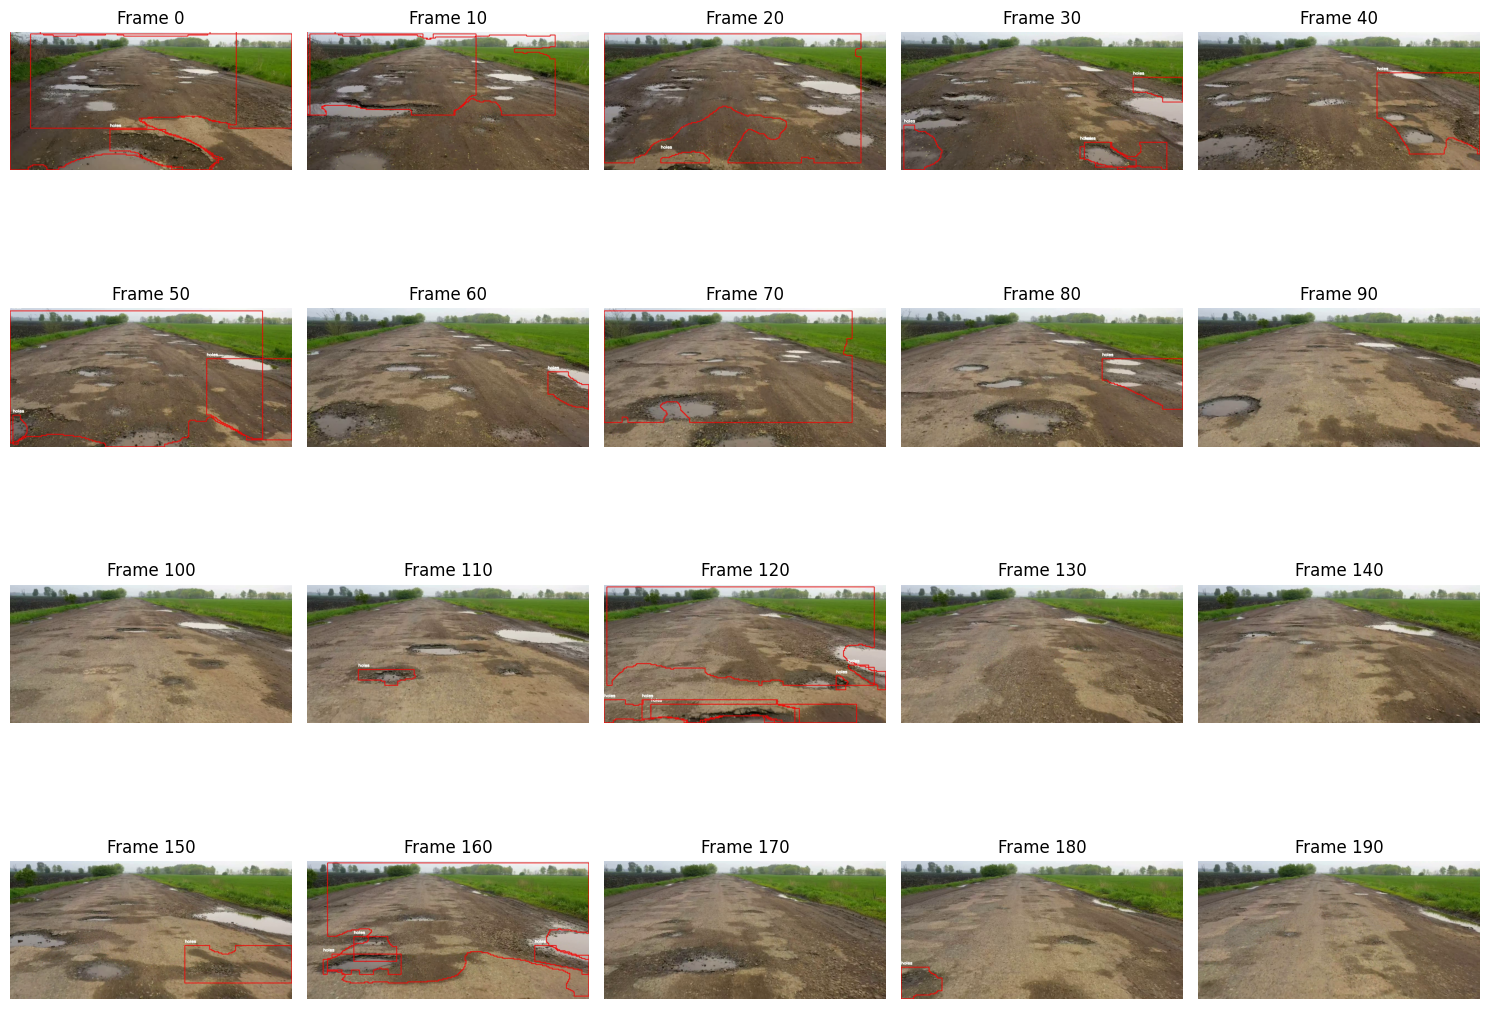

In [146]:
cap = cv2.VideoCapture(output_path)

# Parámetros
frame_interval = 10  # Mostrar un frame cada 20
max_frames = 20      # Mostrar máximo 20 frames

frames = []
count = 0

# Extraer los frames
while len(frames) < max_frames and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if count % frame_interval == 0:
        # Convertir de BGR (OpenCV) a RGB (matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    count += 1

cap.release()

# Mostrar los frames con matplotlib
cols = 5
rows = (len(frames) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i, f in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(f)
    plt.axis('off')
    plt.title(f'Frame {i * frame_interval}')

plt.tight_layout()
plt.show()